In [190]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [191]:
import numpy as np
import pandas as pd

In [192]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [205]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from flask import Flask, jsonify

In [206]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [207]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [208]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [209]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [210]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [211]:
#Measurement first row - getting familiar with the table and the data in it.
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1218232b0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

In [212]:
#Inspector setup
inspector = inspect(engine)

In [213]:
# Gets measurement column names and types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [214]:
#Gets Station first row - getting familiar with the table and the data in it.
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1219865c0>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [215]:
# Gets station column names and types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [216]:
# Gets 10 rows fo data - precipitation and its date
results = session.query(Measurement.prcp, Measurement.date).limit(10).all()
print (results)

dates = [str(result[1]) for result in results[:10]]
prcp = [result[0] for result in results[:10]]

[(0.08, '2010-01-01'), (0.0, '2010-01-02'), (0.0, '2010-01-03'), (0.0, '2010-01-04'), (None, '2010-01-06'), (0.06, '2010-01-07'), (0.0, '2010-01-08'), (0.0, '2010-01-09'), (0.0, '2010-01-10'), (0.01, '2010-01-11')]


In [217]:
# Total dates
session.query(func.count(Measurement.date)).all()

[(19550)]

In [218]:
# Gets the last date entry in the data table
last_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date_row)

('2017-08-23',)


In [219]:
# Calculate the date 1 year ago from the last data point in the database
one_year_back = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_back)

2016-08-23


## Precipitation Analysis

In [220]:
# Sort/Filter the dataframe by date
year_precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_back).\
    order_by(Measurement.date).all()

In [221]:
# Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(year_precipitation)
precipitation_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [222]:
#Drop nan
precipitation_df = precipitation_df.dropna()

In [223]:
#Set the index to the date column
precipitation_df.set_index("date").head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


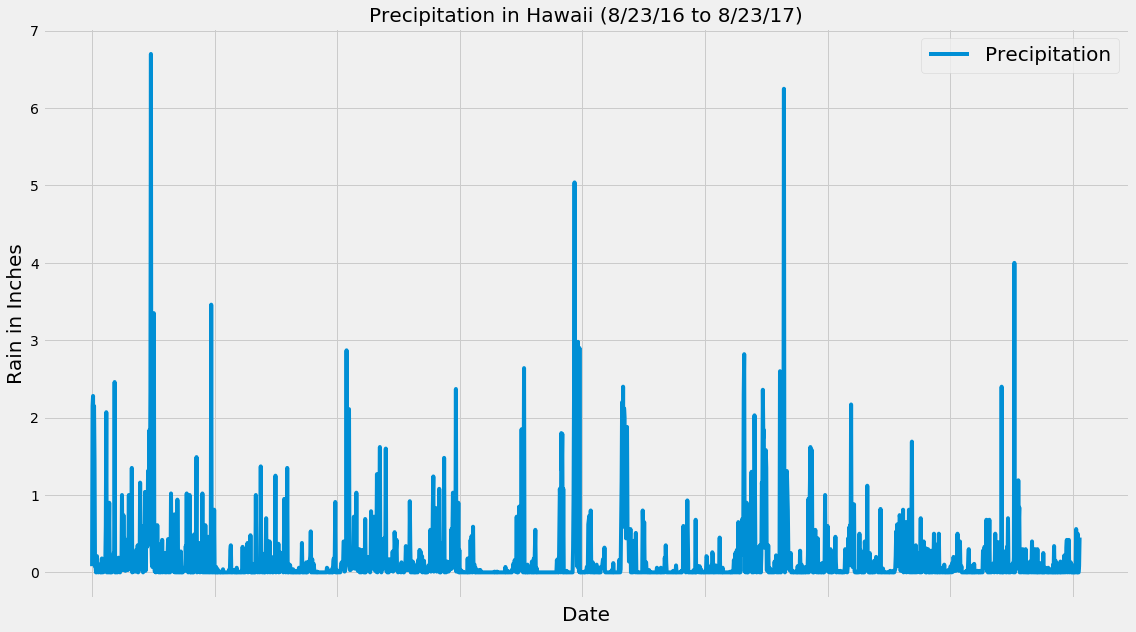

In [224]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot("date", "prcp", figsize = (16, 9))
plt.xlabel("Date", fontsize=20)
plt.ylabel("Rain in Inches", fontsize=20)
plt.title("Precipitation in Hawaii (8/23/16 to 8/23/17)", fontsize=20)
plt.legend(["Precipitation"], fontsize=20)
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

# plt.xlabel('Date', fontsize=20)
# plt.xticks(np.arange(0, 365, 30), rotation=70, fontsize=12)


In [225]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [226]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
print(stations)

9


In [227]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
        
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [228]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station

tobs_summary = [
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]
                
session.query(*tobs_summary).filter(Measurement.station=="USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

In [229]:
# Choose the station with the highest number of temperature observations.
highest_tobs = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= one_year_back).all()

highest_tobs_df=pd.DataFrame(highest_tobs)
highest_tobs_df.head()

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


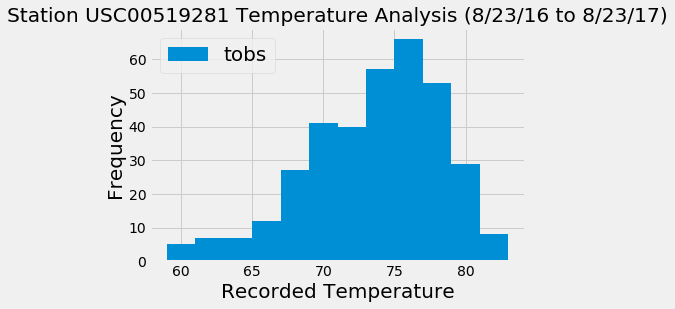

<Figure size 1080x1440 with 0 Axes>

In [231]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(highest_tobs_df['tobs'],12,)
plt.xlabel("Recorded Temperature", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.title("Station USC00519281 Temperature Analysis (8/23/16 to 8/23/17)")
plt.legend(["tobs"], fontsize=20)
plt.figure(figsize = (15,20))
plt.show()

# <font color='red'> Will try to work on optional later</font>

## Optional: Other Recommended Analyses

* The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.

## Temperature Analysis

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


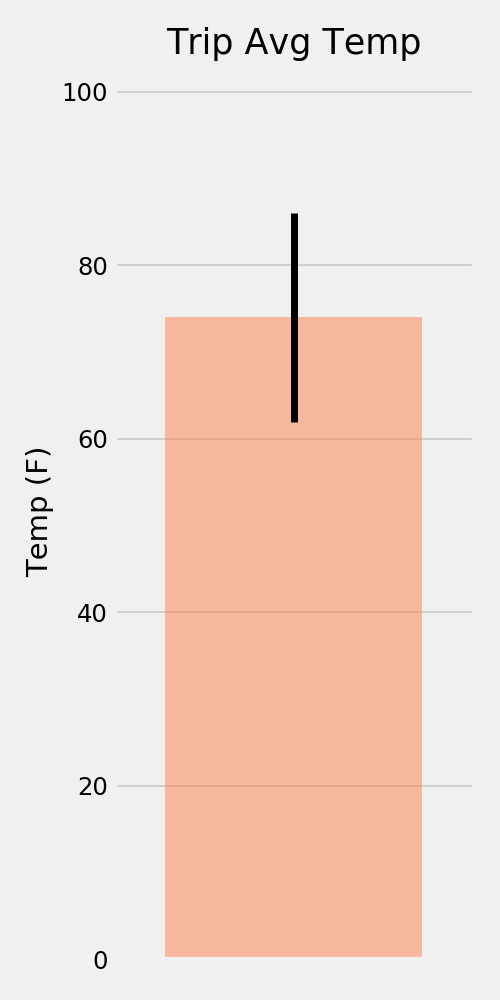

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


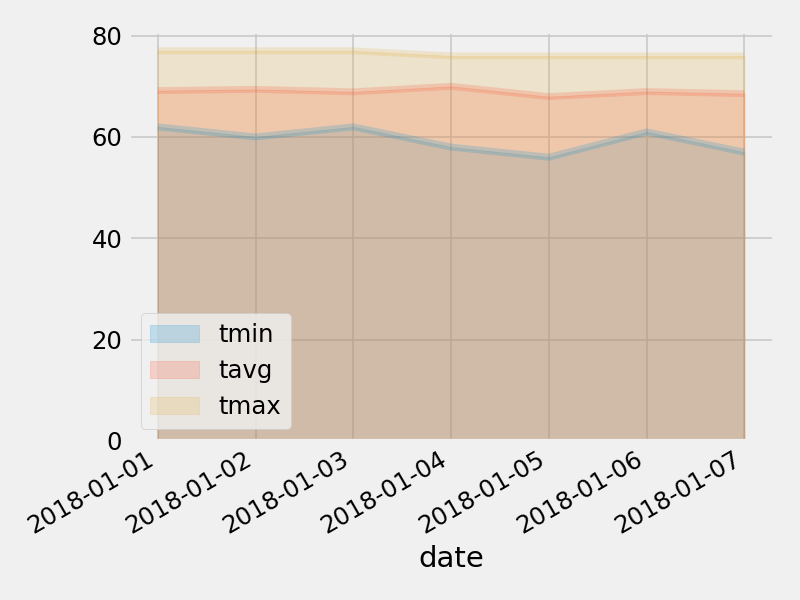

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
